In [ ]:
import json
data = {
    "message": "success"
}

serialized = json.dumps(data) # 직렬화
print(serialized)

In [ ]:
data = json.loads(serialized) # 역직렬화
print(data)

In [ ]:
book_data: str = """
[
    {"name": "혼자 공부하는 데이터분석", "author": "박해선", "year": 2022},
    {"name": "혼자 공부하는 머신러닝+딥러닝", "author": "박해선", "year": 2020}
]
"""
deserialized = json.loads(book_data)
print(deserialized[1]["year"])

In [ ]:
import pandas as pd
import io

# 25.01.14 기준 read_json이 deprecated 될 예정이라고 뜬다
# 해결하기 위해서는 import io -> io.StringIO로 json을 감싸야함
pd.read_json(io.StringIO(book_data)) # pandas 데이터프레임으로 json 데이터를 자동으로 역직렬화


In [ ]:
xml_str = """
<book>
    <name>혼자 공부하는 데이터분석</name>
    <author>박해선</author>
    <year>2022</year>
</book>
"""

import xml.etree.ElementTree as et
book = et.fromstring(xml_str) # x_str xml 문자열을 실제 XML로 변환 (직렬화)
print(type(book)) # 타입 조회
print(book.tag) # 최상위 Element 조회

In [ ]:
# 자식 Element 조회 시
book_childs = list(book)
print(*book_childs)

for child in book_childs:
    print(child.tag + " : " + child.text)


In [ ]:
xml_str = """
<books>
    <book>
        <name>혼자 공부하는 데이터분석</name>
        <author>박해선</author>
        <year>2022</year>
    </book>
    <book>
        <name>혼자 공부하는 머신러닝+딥러닝</name>
        <author>박해선</author>
        <year>2022</year>
    </book>
</books>
"""
books = et.fromstring(xml_str)
print(books.tag) # 최상위 Element

In [ ]:
for book in books.findall('book'): # 여러개의 자식 Element 조회 시
    for element in book:
        print(element.tag + " : " +element.text)

# API 호출을 통해 데이터 수집하기 - 서울시 공공자전거 실시간 대여 현황 API

In [ ]:
# 1. Requests 라이브러리를 사용해서 API를 호출하는 방법
import os
from dotenv import load_dotenv
import requests
import pandas as pd

load_dotenv(".env")

API_KEY = os.getenv("PUBLIC_BICYCLE_API_KEY")
if API_KEY is None:
    print("PUBLIC_BICYCLE_API_KEY is not defined")
    exit(1)

start_offset=1
limit=5

In [ ]:
response = requests.get(
    url=f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/bikeList/{start_offset}/{limit}/",
)
public_bike_dataframe = None
if response.status_code == 200:
    fetched_data = response.json()

    rows = fetched_data["rentBikeStatus"]["row"]

    public_bike_dataframe = pd.DataFrame(rows)
    public_bike_dataframe.sort_values(by="shared", inplace=True) # inplace=True로 반영해야함
    print(public_bike_dataframe)
else:
    print("error!!")

In [ ]:
import json

if public_bike_dataframe is not None:
    # Dataframe을 Json으로 변환
    # force_ascii=False : 한글을 유니코드로 변환하지 않고 그대로 출력하도록 설정
    # lines=False : JSON 데이터를 하나의 배열로 묶어서 저장
    json_data = public_bike_dataframe.to_json(orient="records", force_ascii=False, lines=False)

    # JSON을 pretty-print로 변환해서 저장
    parsed_json = json.loads(json_data)
    with open("./data/public_bike_rent_information.json", "w") as f:
        json.dump(parsed_json, f, indent=4, ensure_ascii=False)

else:
    print("error!!")


In [ ]:
# 1. 도서관 정보나루 인기도서 데이터 수집 (API)
import requests
import dotenv
import os
import pandas as pd
dotenv.load_dotenv(".env")
API_KEY = os.getenv("PUBLIC_LIBRARY_API_KEY")
response = requests.get(
    url=f"https://data4library.kr/api/loanItemSrch?authKey={API_KEY}&&age=20&startDt=2025-01-01&endDt=2025-01-14&format=json"
)

books = list()
if response.status_code == 200:
    data = response.json()
    for book in data["response"]["docs"]:
        books.append(book["doc"])
else:
    print("error!!")

books_df = pd.DataFrame(books)
books_df



In [ ]:
json_data = books_df.to_json(orient="records", force_ascii=False, lines=False)

# JSON을 pretty-print로 변환해서 저장
parsed_json = json.loads(json_data)
with open("./data/20s_best_book.json", "w") as f:
    json.dump(parsed_json, f, indent=4, ensure_ascii=False)


# 웹 스크래핑으로 데이터 수집하기 - YES24 크롤링


In [98]:
books_df = pd.read_json('./data/20s_best_book.json')

# 원하는 헤더만 선택
# select_headers = ["no", "ranking", "bookname", "authors", "publisher", "publication_year", "isbn13"]
# books_df = books_df[select_headers]

# 또는 슬라이싱으로 선택
books_df = books_df.loc[:, "no":"isbn13"]
books_df.head()

,no,ranking,bookname,authors,publisher,publication_year,isbn13
0,1,1,"물고기는 존재하지 않는다 :상실, 사랑 그리고 숨어 있는 삶의 질서에 관한 이야기",룰루 밀러 지음 ;정지인 옮김,곰출판,2021,9791189327156
1,2,2,소년이 온다 :한강 장편소설,지은이: 한강,창비,2014,9788936434120
2,3,3,지구 끝의 온실 :김초엽 장편소설,지은이: 김초엽,Giant Books(자이언트북스),2021,9791191824001
3,4,4,모순 :양귀자 장편소설,지은이: 양귀자,쓰다,2013,9788998441012
4,5,5,작별하지 않는다 :한강 장편소설,지은이: 한강,문학동네,2021,9788954682152


In [99]:
# 행과 열 선택해서 출력
# 0행, 3행의 bookname열과 isbn열 출력
books_df.loc[[0, 3], ["bookname", "isbn13"]]

,bookname,isbn13
0,"물고기는 존재하지 않는다 :상실, 사랑 그리고 숨어 있는 삶의 질서에 관한 이야기",9791189327156
3,모순 :양귀자 장편소설,9788998441012


In [107]:
import asyncio
import aiohttp

async def fetch(session, url):
    async with session.get(url) as resp:
        return await resp.text()

async def fetch_all(url_list):
    async with aiohttp.ClientSession(headers=headers) as session:
        tasks = [fetch(session, url) for url in url_list]
        return await asyncio.gather(*tasks)

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
ISBN_list = books_df["isbn13"].tolist()
base_url = "https://www.yes24.com"
book_url_list = [base_url + f"/Product/Search?domain=BOOK&query={str(isbn)}" for isbn in ISBN_list]

async def main(url_list: list):
    results = await fetch_all(url_list)
    return results

html_list = await main(book_url_list) # 빨간줄 나오는데, 무시해도 됨. Jupyter notebook은 이렇게 실행해야함

In [108]:
print(f"{len(html_list)} 개 가져옴")

200 개 가져옴


In [109]:
print(html_list[0])






	<!DOCTYPE html >
	<html lang="ko">

<head>
	<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
	<meta http-equiv="Content-Type" content="text/html;charset=utf-8" />
	<meta http-equiv="Accept-CH" content="dpr, width, viewport-width, rtt, downlink, ect, UA, UA-Platform, UA-Arch, UA-Model, UA-Mobile, UA-Full-Version" />
	<meta http-equiv="Accept-CH-Lifetime" content="86400" />
	<meta name="referrer" content="unsafe-url" />
	<meta name="viewport" content="width=1170" />

	<title> 9791189327156 - 예스24</title> 

	<meta name="title" content="예스24" />
	<meta name="description" content="YOUR EVERY STORY 문화 콘텐츠 플랫폼, 예스24" />
	<meta name="keywords" content="인터넷 서점, 온라인 쇼핑, 상품 추천, 쇼핑몰, 상품 검색, 도서 정보, 국내도서, 외국도서, 전자책, eBook, 이북, 크레마, 공연, 콘서트, 뮤지컬, 음반, 예매, DVD, 블루레이, 예스24, YES24, 교보문고, 알라딘, 리센스, 예스24 도서용품, 친환경 PB 브랜드, 사은품, 굿즈" />


	<link title="YES24" rel="search" type="application/opensearchdescription+xml" href="//www.yes24.com/OpensearchDescription.xml">

	<script type="text/javascript

In [125]:
from bs4 import BeautifulSoup

book_detail_links = []
for html in html_list:
    soup = BeautifulSoup(html, 'html.parser')
    detail_link = soup.find('a', attrs={'class':'gd_name'}) # 개발자도구 켜고 select 버튼을 통해 상세 링크가 어디에 달려있는지 알 수 있음 -> class=gd_name의 a 태그에 존재함
    if detail_link is None: # 가져온 html 구조에 이게 없을수도 있음 -> 무시
        continue
    book_detail_links.append(base_url + detail_link['href'])
print(f"{len(book_detail_links)} 개 가져옴")
print(f"{book_detail_links[0]}")

198 개 가져옴
https://www.yes24.com/Product/Goods/105526047









	<!DOCTYPE html >
	<html lang="ko">

<head><link rel="canonical" href="https://www.yes24.com/product/goods/105526047">
	<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
	<meta http-equiv="Content-Type" content="text/html;charset=utf-8" />
	<meta http-equiv="Accept-CH" content="dpr, width, viewport-width, rtt, downlink, ect, UA, UA-Platform, UA-Arch, UA-Model, UA-Mobile, UA-Full-Version" />
	<meta http-equiv="Accept-CH-Lifetime" content="86400" />
	<meta name="referrer" content="unsafe-url" />
	<meta name="viewport" content="width=1170" />

	<title>물고기는 존재하지 않는다 - 예스24 </title> 

	
<meta name="title" content="물고기는 존재하지 않는다"/>
<meta name="author" content="룰루 밀러 저/정지인 역" />
	
<meta name="description" content="상실, 사랑 그리고 숨어 있는 삶의 질서에 관한 이야기. 룰루 밀러 저/정지인 역. 곰출판. 판매가 15,300원(10% 할인). 포인트 850원(5% 적립). ‘방송계의 퓰리처상’ 피버디상 수상자 룰루 밀러의사랑과 혼돈, 과학적 집착에 관한 경이롭고도 충격적..."/>
	
<meta name="keywords" content="대장금_출판사대표추천도서,2023경남독서한마당선정도서,2022내맘대로올해의책,올해의책,책나눔위원회추천도서,청년의날추천도서,크레마클럽에있어요,책읽아웃,북클
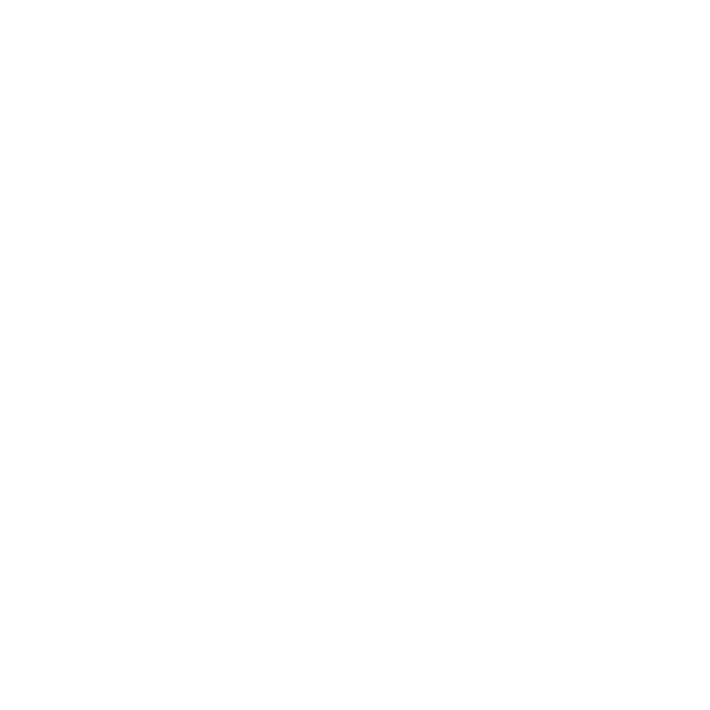
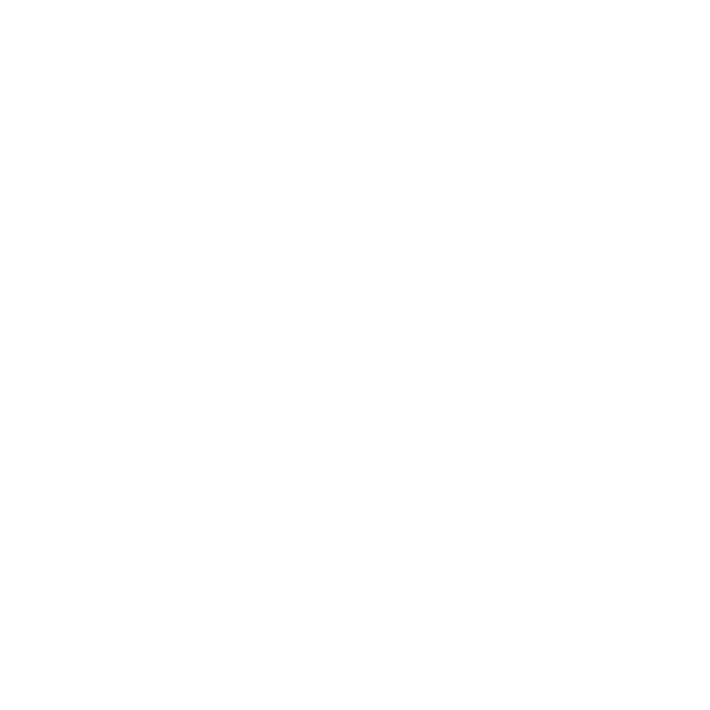
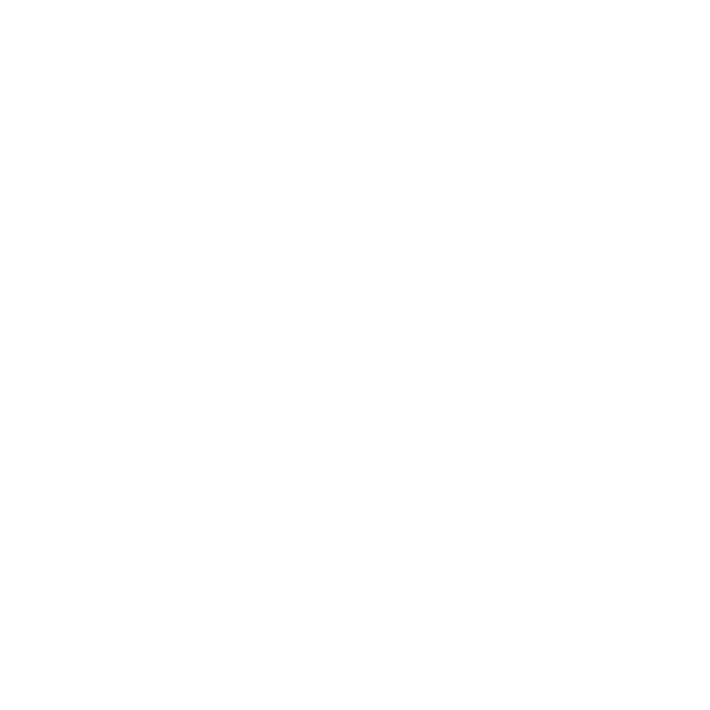
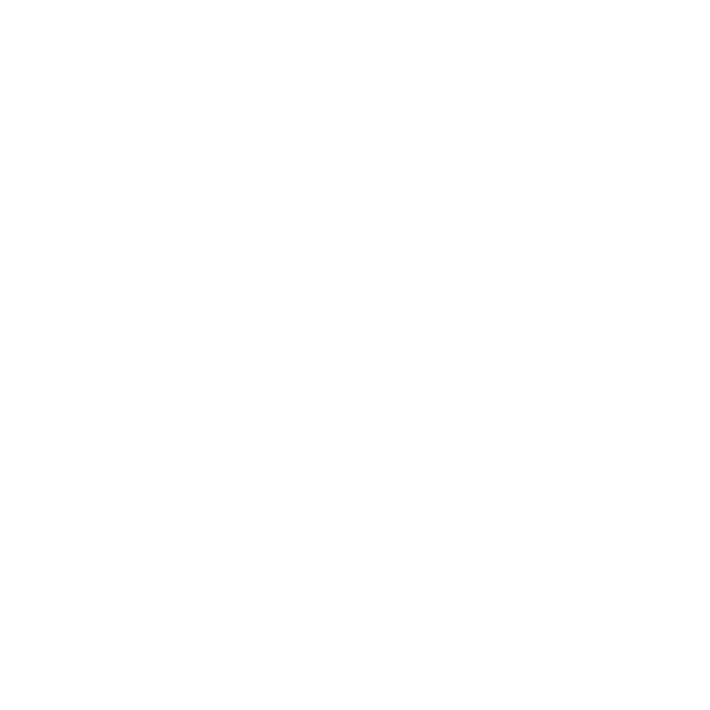
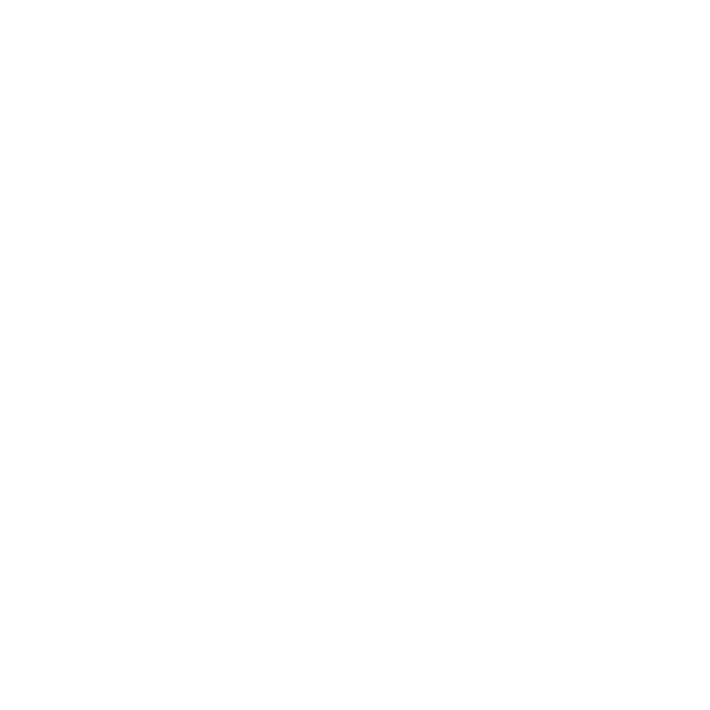
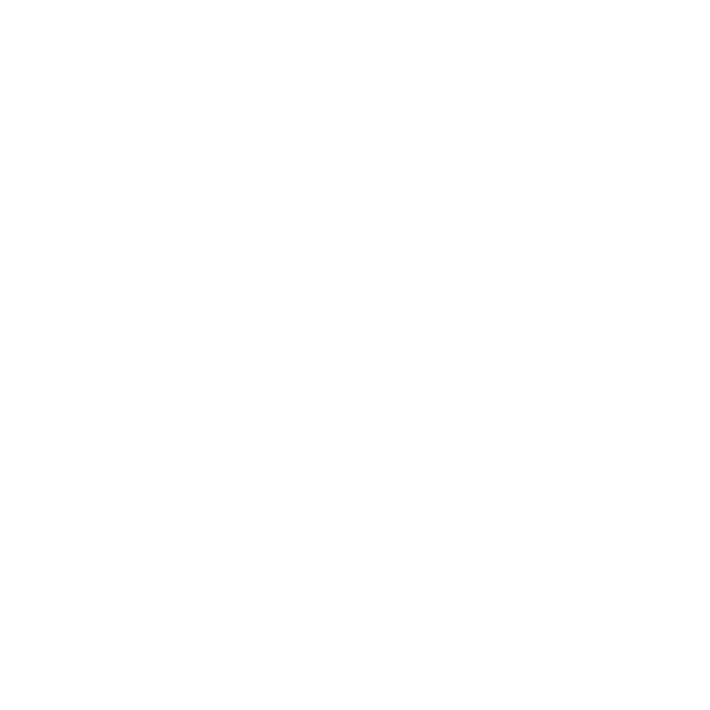
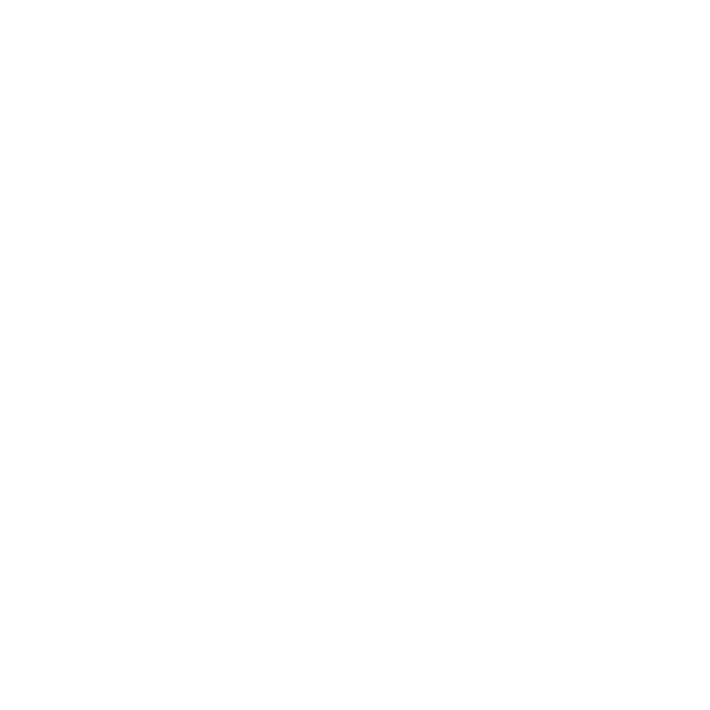
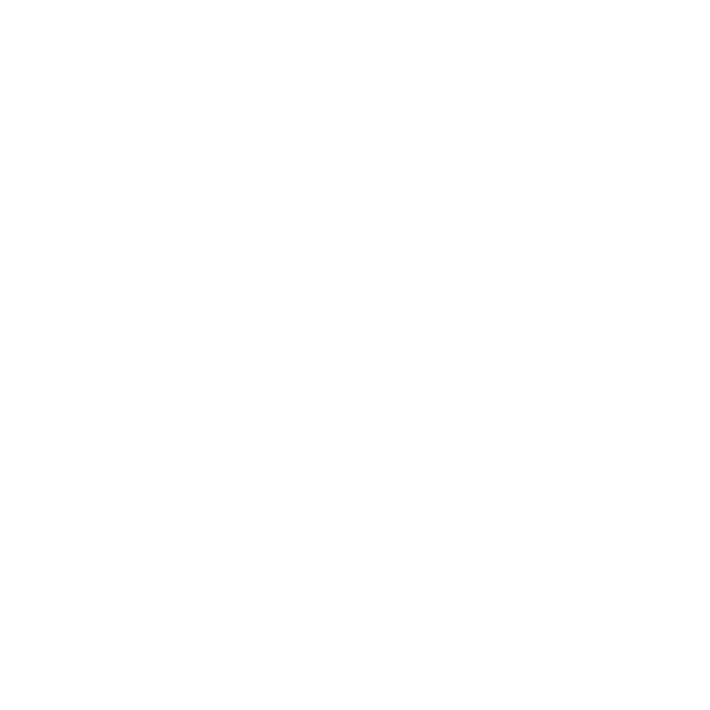
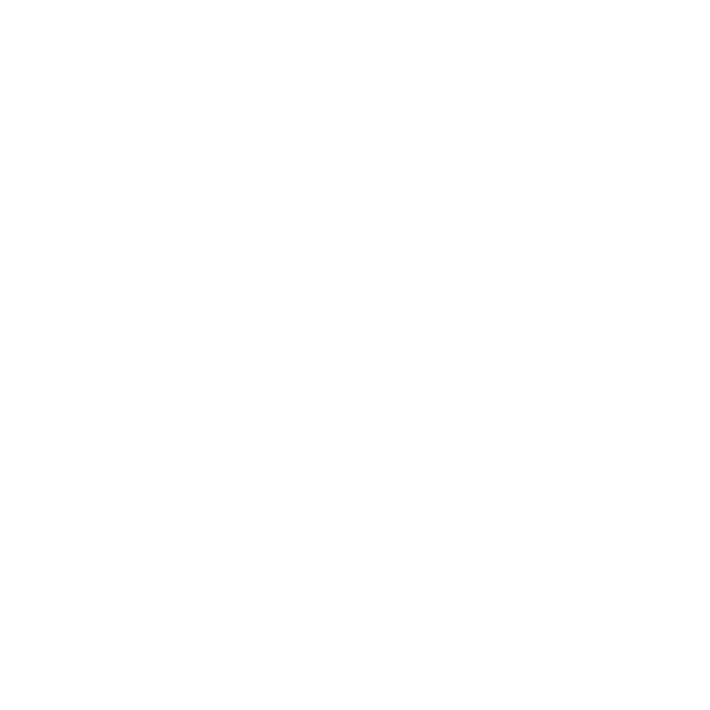
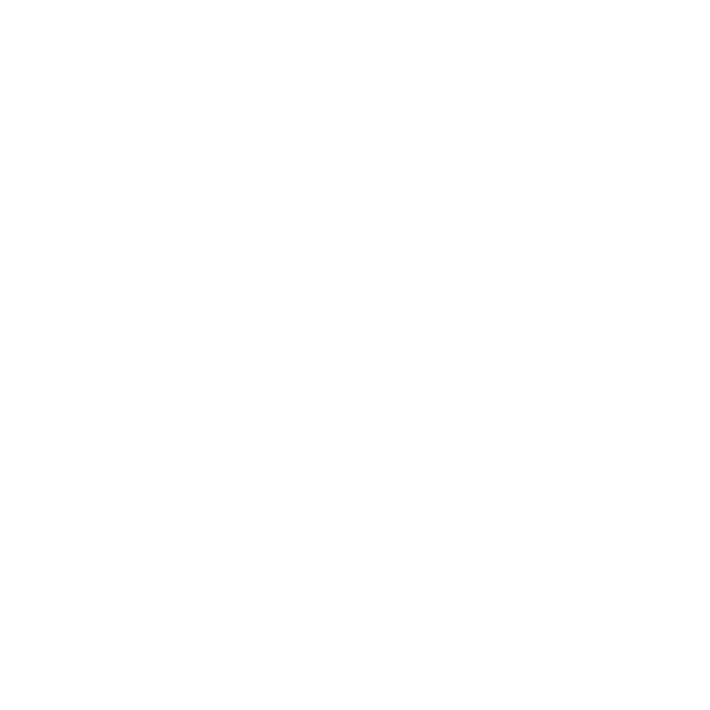

In [126]:
# 상세페이지마다 들어가서 디테일 html 가져오기
book_detail_htmls = await main(book_detail_links)
print(book_detail_htmls[0])

In [131]:
# 디테일 페이지에 있는 쪽수 정보 추출
pages_list = []
for html in book_detail_links:
    soup = BeautifulSoup(book_detail_htmls[0], 'html.parser')
    table = soup.find('table', attrs={'class':'tb_nor'})
    tr_list = table.find_all('tr')
    pages = tr_list[1].find('td').text.split('|')[0].strip()
    pages_list.append(pages)

print(len(pages_list))

198


# 전체 과정을 한번에 수행해보자

In [141]:
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import re

books_df = pd.read_json('./data/20s_best_book.json').loc[:, "no":"isbn13"]
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}
base_url = "https://www.yes24.com"
ISBN_list = books_df["isbn13"].tolist()
book_url_list = [
    f"{base_url}/Product/Search?domain=BOOK&query={isbn}" for isbn in ISBN_list
]


async def fetch(session, url):
    try:
        async with session.get(url, timeout=10) as resp:
            resp.raise_for_status()
            return await resp.text()
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

async def fetch_all(url_list):
    tasks = []
    async with aiohttp.ClientSession(headers=headers) as session:
        for url in url_list:
            if url == 'NULL':
                tasks.append(asyncio.sleep(0)) # HTML 파싱했을 때 링크가 없는 경우, 그냥 None 처리
            else:
                tasks.append(fetch(session, url))
        return await asyncio.gather(*tasks)

async def fetch_detail_link(html_list):
    result = []
    for html in html_list:
        if html is None:
            result.append('NULL')
            continue
        soup = BeautifulSoup(html, 'html.parser')
        link = soup.find('a', attrs={'class': 'gd_name'})
        if link is None:
            result.append('NULL')
        else:
            href = link.get('href', '')
            full_link = base_url + href if href else 'NULL'
            result.append(full_link)
    return result

async def parse_pages_info(html_list):
    pages_list = []
    for html in html_list:
        if html is None:
            pages_list.append('NULL')
            continue
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table', attrs={'class': 'tb_nor'})
        if table:
            tr_list = table.find_all('tr')
            if len(tr_list) > 1:
                td = tr_list[1].find('td') # 쪽수 정보는 2번째 (배열기준 1번째)에 위치해 있음
                if td:
                    pages_text = td.get_text()
                    pages = pages_text.split('|')[0].strip()
                    pages_list.append(pages)
                    continue
        pages_list.append('NULL')  # 페이지 정보가 없을 경우
    return pages_list

async def main(url_list):
    print("검색 페이지 HTML 리스트 가져오기...")
    search_htmls = await fetch_all(url_list)

    print("검색 페이지 HTML에서 상세 링크 추출하기...")
    links = await fetch_detail_link(search_htmls)

    print("각 상세링크마다 들어가서 HTML 정보 가져오기...")
    detail_htmls = await fetch_all(links)

    print("각 상세페이지 HTML에서 Pages 정보 가져오기...")
    pages = await parse_pages_info(detail_htmls)

    # 원본 DataFrame에 쪽수 정보 추가
    pattern = re.compile(r'(\d+)쪽$')
    processed_pages = []
    for page in pages:
        if page == 'NULL':
            processed_pages.append('NULL')
            continue
        match = pattern.search(page)
        if match:
            processed_pages.append(match.group(1))
        else:
            processed_pages.append('NULL')

    books_df["pages"] = processed_pages

# 이벤트 루프를 사용하여 main 함수 실행
if __name__ == "__main__":
    await main(book_url_list)
    print("데이터 처리 완료")


검색 페이지 HTML 리스트 가져오기...
검색 페이지 HTML에서 상세 링크 추출하기...
각 상세링크마다 들어가서 HTML 정보 가져오기...
각 상세페이지 HTML에서 Pages 정보 가져오기...
데이터 처리 완료


In [142]:
books_df.head(5)

,no,ranking,bookname,authors,publisher,publication_year,isbn13,pages
0,1,1,"물고기는 존재하지 않는다 :상실, 사랑 그리고 숨어 있는 삶의 질서에 관한 이야기",룰루 밀러 지음 ;정지인 옮김,곰출판,2021,9791189327156,300
1,2,2,소년이 온다 :한강 장편소설,지은이: 한강,창비,2014,9788936434120,216
2,3,3,지구 끝의 온실 :김초엽 장편소설,지은이: 김초엽,Giant Books(자이언트북스),2021,9791191824001,392
3,4,4,모순 :양귀자 장편소설,지은이: 양귀자,쓰다,2013,9788998441012,NULL
4,5,5,작별하지 않는다 :한강 장편소설,지은이: 한강,문학동네,2021,9788954682152,332


# 다음과 같은 DataFame df가 있을 때, loc 메서드의 결과가 다른 것은?

|     | col1 | col2 |
|-----|------|------|
| 0   | a    | 1    |
| 1   | b    | 2    |
| 2   | c    | 3    |

1. df.loc[[0,1,2], ['col1', 'col2']
2. df.loc[0:2, 'col1': 'col2']
3. df.loc[:2, 'col1': 'col2']
4. df.loc[::2, 'col1': 'col2'] -> 이건 2칸씩 step이 증가하기 때문에 1,2,3과는 다른 결과가 나온다